**Классификация изображений: Cats vs Dogs**

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по ссылке. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.
Датасет

# Library

In [29]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19

print(tf.__version__)
print(tf.executing_eagerly())

2.8.2
True


# Load data

In [22]:
!pip install -q kaggle

from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [23]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

mkdir: cannot create directory ‘/root/.kaggle’: File exists
dogs-vs-cats-redux-kernels-edition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [24]:
import zipfile

z = zipfile.ZipFile('dogs-vs-cats-redux-kernels-edition.zip')
z.printdir()

File Name                                             Modified             Size
sample_submission.csv                          2019-12-11 04:18:02       113903
test.zip                                       2019-12-11 04:18:06    284478493
train.zip                                      2019-12-11 04:18:34    569918665


In [25]:
z.extract('train.zip')
z.extract('test.zip')
with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
with zipfile.ZipFile('/content/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [26]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg19.preprocess_input(img)  # предобработка для vgg19

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

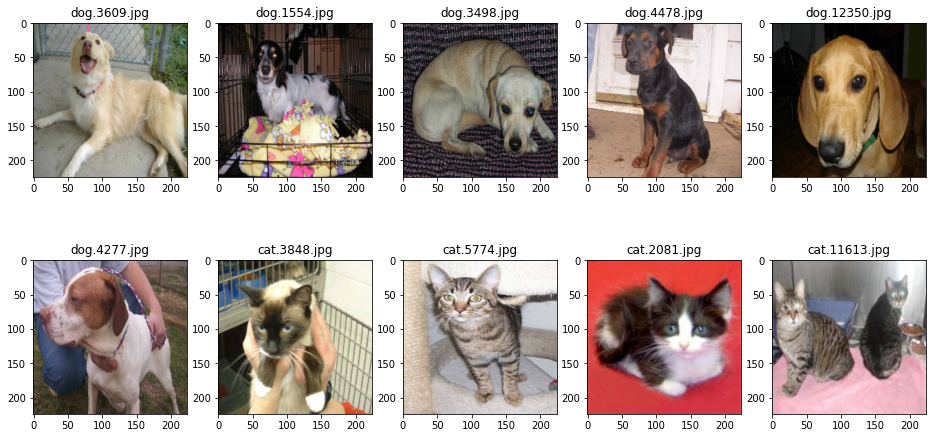

In [27]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [31]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg19.VGG19(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

80150528/80134624 [==============================] - 1s 0us/step


In [32]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [45]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.Conv2D(filters=6,
                        kernel_size=(5, 5),
                        padding='same',
                        activation='relu',
                        )(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid')(x)
x = tf.keras.layers.Conv2D(filters=16, 
                        kernel_size=(3, 3),
                        padding='same',
                        activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [46]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [47]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [48]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 3s 264ms/step - loss: 0.3040 - accuracy: 0.8687 - val_loss: 7.3749e-04 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 2s 231ms/step - loss: 0.1991 - accuracy: 0.9281 - val_loss: 6.9685e-04 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 2s 249ms/step - loss: 0.0724 - accuracy: 0.9812 - val_loss: 6.8471e-04 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 2s 224ms/step - loss: 0.0616 - accuracy: 0.9750 - val_loss: 6.8060e-04 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 2s 228ms/step - loss: 0.0885 - accuracy: 0.9719 - val_loss: 6.7652e-04 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 2s 231ms/step - loss: 0.1936 - accuracy: 0.9625 - val_loss: 6.7334e-04 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 3s 269ms/step - loss: 0.1084 - accuracy: 0.9719 - val_loss: 8.062

In [49]:
model.save('cats-dogs-vgg19.hdf5')

In [50]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

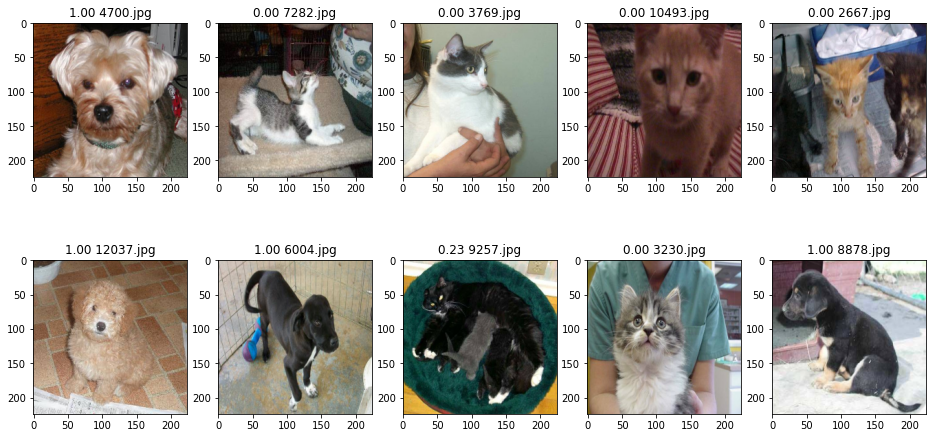

In [51]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [52]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [53]:
!head submit.txt

id,label
4700,1.000000
7282,0.000009
3769,0.000000
10493,0.000002
2667,0.000143
12037,0.999977
6004,1.000000
9257,0.225196
3230,0.000000
